# h5py explanation to.self()

The f['CartesianVolumes'] is an HDF5 Group, containing 15 members (volumes)

cartesian_volumes['vol01'] is a HDF5 dataset named 'vol01', shape=(186, 186, 186) and a type="|u1"

Doing vol01.shape would then return the shape-tuple. That is, .shape always returns a tuple containing the shape

The [:] statement accessess the value that is stored inside the key

The .keys() function returns the dictionarys keys

The .h5 files are organized as

filename.h5 - (Type: HDF5 Group, Filetype: HDF5,  size=70324K,  groups=2,  datasets=17)

	CartesianVolumes (Type: HDF5 Group)
		vol01 (Type: HDF5 Dataset)
		
	ImageGeometry (Type: HDF5 Group)
		dirX (Type: HDF5 Dataset)
		
next_filename.h5 (...)




# Code description

The following code expects a preprocessed ultrasound image (Blurring and filtering). It nomalizes the pixel values to [0 1] and stores the reference- and moving volumes in a data_norm variable of size ([2, 214, 214, 214])

In [1]:
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import utils as ut

%matplotlib inline

In [2]:
PROJ_ROOT = '/users/kristofferroise/project'
patient_group = 'patient_data/gr5_STolav5to8'
patient = 'p7_3d'

fixed_file = 'J249J70K_proc.h5'
moving_file = 'J249J70M_proc.h5'

fixed = os.path.join(PROJ_ROOT, '{}/{}/{}'.format(patient_group, patient, fixed_file))
moving = os.path.join(PROJ_ROOT, '{}/{}/{}'.format(patient_group, patient, moving_file))

num_volumes = 2

with h5py.File(fixed, 'r') as fix, h5py.File(moving, 'r') as mov:
    # Loads all volumes
    fixed_volumes = fix['CartesianVolumes']
    moving_volumes = mov['CartesianVolumes']
    
    # Sets vol01 equal to the data values in 'vol01'. Has shape (214, 214, 214) and type numpy.ndarray
    fix_vol01 = fixed_volumes['vol01'][:]
    mov_vol01 = moving_volumes['vol02'][:]
    
    shape = list(mov_vol01.shape)
    shape = (num_volumes, shape[0], shape[1], shape[2])
    
    data = torch.empty(shape)
    print(data.shape)

    data[0] = torch.from_numpy(fix_vol01)
    data[1] = torch.from_numpy(mov_vol01)

torch.Size([2, 214, 214, 214])


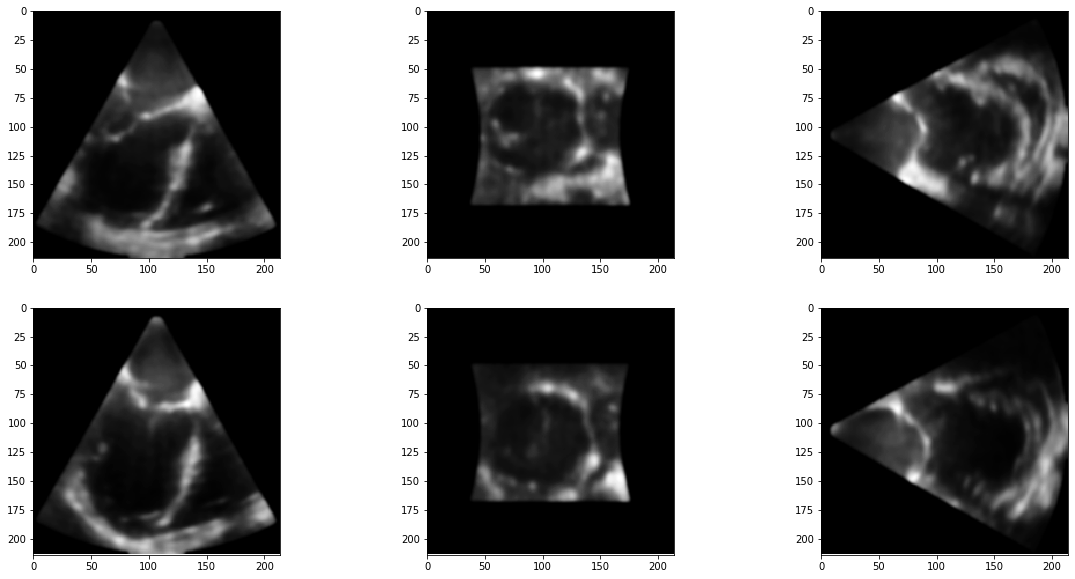

In [3]:
# Plotting of the normalized, pre-processed volumes

ut.show_dual(data, num_volumes, shape)

# Patching of 3D volumes
Try the torch.tensor.Unfold function to patch the 3D images.

In [4]:
data = ut.normalize_pixels(data)

In [7]:
import get_patch as util
import time
from torch.nn import functional as F

stride = 20
patch_size = 20

mod = len(data[0,:])%patch_size

if mod != 0:
    pad_size = patch_size - mod
    padded = F.pad(data, (pad_size,0,pad_size,0,pad_size,0))
    data = padded

data_size = data.shape
N = data_size[0]

start = time.time() * 1
for i in range(N):
    flat_idx = util.calculatePatchIdx3D(1, patch_size * torch.ones(3), data_size[1:], stride * torch.ones(3))
    flat_idx_select = torch.zeros(flat_idx.size())
    
    for patch_idx in range(1, flat_idx.size()[0]):
        patch_pos = util.idx2pos_4D(flat_idx[patch_idx], data_size[1:])
        
        moving_patch = data.data[i-1, 
                                 patch_pos[1]:patch_pos[1] + patch_size, 
                                 patch_pos[2]:patch_pos[2] + patch_size, 
                                 patch_pos[3]:patch_pos[3] + patch_size]
        fixed_patch = data.data[i, 
                                 patch_pos[1]:patch_pos[1] + patch_size, 
                                 patch_pos[2]:patch_pos[2] + patch_size, 
                                 patch_pos[3]:patch_pos[3] + patch_size]
        
        if (torch.sum(moving_patch) + torch.sum(fixed_patch) != 0):
            flat_idx_select[patch_idx] = 1
        #end if
    #end for
    flat_idx_select = flat_idx_select.bool()
    flat_idx = torch.masked_select(flat_idx, flat_idx_select)
    
    input_batch = torch.zeros(flat_idx.shape[0], 2, patch_size, patch_size, patch_size)

    for slices in range(flat_idx.shape[0]):
        patch_pos = util.idx2pos_4D(flat_idx[slices], data_size[1:])
        input_batch[slices, 0] = data.data[i-1, 
                                             patch_pos[1]:patch_pos[1] + patch_size, 
                                             patch_pos[2]:patch_pos[2] + patch_size,
                                             patch_pos[3]:patch_pos[3] + patch_size]
        input_batch[slices, 1] = data.data[i,
                                             patch_pos[1]:patch_pos[1] + patch_size,
                                             patch_pos[2]:patch_pos[2] + patch_size,
                                             patch_pos[3]:patch_pos[3] + patch_size]
    #end for
#end for
stop = time.time() * 1
print(stop-start)

1.2431020736694336


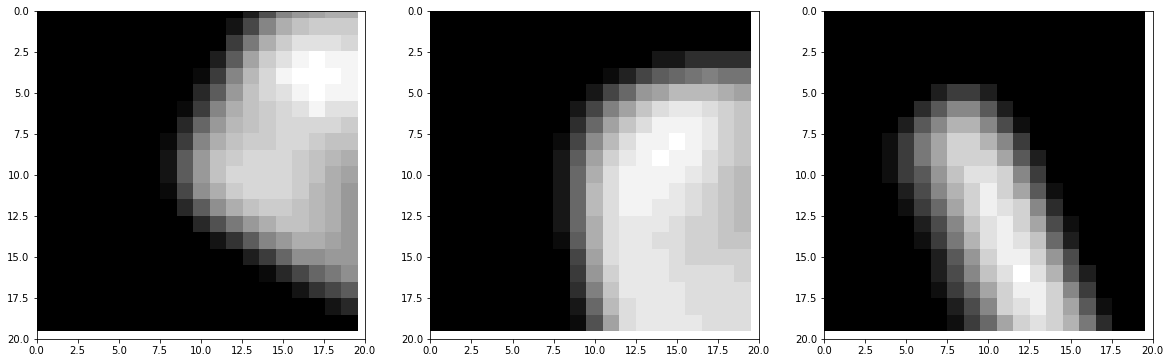

torch.Size([2, 20, 20, 20])
torch.Size([20, 20, 20])
torch.Size([649, 2, 20, 20, 20])


In [8]:
ut.show_single(input_batch[31,:], input_batch[565,:].shape)
print(input_batch[91,:].shape)
print(input_batch[564,0,:].shape)
print(input_batch.shape)

54
26
torch.Size([2, 240, 240, 240])
torch.Size([2, 240, 240, 240])
torch.Size([2, 3, 3, 3, 80, 80, 80])
torch.Size([2459595])
torch.Size([2, 240, 240, 240])


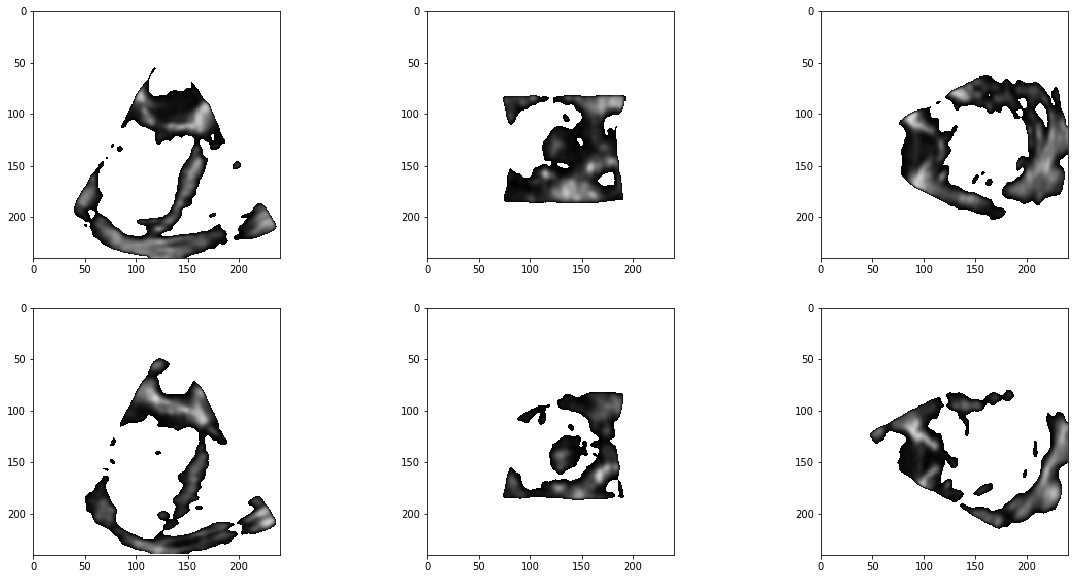

In [5]:
from torch.nn import functional as F

size = 80
stride = 80

mod = len(data[0,:])%size

if mod != 0:
    print(mod)
    pad_size = size - mod
    print(pad_size)
    padded = F.pad(data, (pad_size,0,pad_size,0,pad_size,0))
    data = padded

print(data.shape)

print(padded.shape)

patches = data.unfold(1, size, stride).unfold(2, size, stride).unfold(3, size, stride)

patches = ut.normalize_pixels(patches)

y = torch.ones(patches.shape)
x = patches.clone().detach()

new_patch = torch.empty(patches.shape)

new_patch = torch.where(patches >= 0.15, x, y)
print(new_patch.shape)


mask = new_patch[new_patch != 1]
print(mask.shape)

'''
new_patch = torch.flatten(new_patch)
new_patch = torch.masked_select(new_patch, mask)'''

#patches = torch.from_numpy(patches)

#re = new_patch.permute(0, 1, 5, 2, 4, 3, 6).contiguous().view_as(data)
re = new_patch.permute(0, 1, 4, 2, 5, 3, 6).contiguous().view_as(data)
print(re.shape)

ut.show_dual(re, num_volumes, re.shape)



In [215]:
#with h5py.File(file, 'r') as f:
    #cartesian_volumes = f['CartesianVolumes']
    #vol01 = cartesian_volumes['vol01']
    #image_geometry = f['ImageGeometry']
    #frameNumber = image_geometry['frameNumber'][:]
    #dirX = image_geometry['dirX']
    #iter(image_geometry)
    #print(cartesian_volumes)
    #print(vol01.shape)
    #shape = image_geometry['resolution']
    
    
    #print(image_geometry.keys())
    #print(image_geometry.values())
    
    #print(len(image_geometry['dirX'][:]))
    #print(len(image_geometry['origin'][:]))
    #print(type(image_geometry['origin'][:]))

    #cv_shape_vol01 = cartesian_volumes['vol01'][:]
    #cv_shape_list = list(cartesian_volumes['vol01'][:].shape)
    #print(type(cv_shape_vol01))
    #print(cv_shape_list)
    #print(type(cv_shape_list))
    #print(cv_shape_vol01[111,112,115])
    #print(len(cv_shape_vol01[1,1,:]))
    
    #shape = (15,186,186,186)
    #print(list(shape))
    
    #data = torch.from_numpy(cv_shape_list)
    #print(data)
    #print(type(data))